In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

exper = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180306_14_58_12_dcnn_mc1v1_150000E_lr2e02")

exper_hdl = ExperimentHandler(exper, use_logfile=False)
exper_hdl.set_root_dir("/home/jorg/repository/dcnn_acdc")

Load from /home/jorg/repository/dcnn_acdc/logs/20180306_14_58_12_dcnn_mc1v1_150000E_lr2e02/stats/exper_stats.dll


In [3]:
model = exper_hdl.load_checkpoint(verbose=False, drop_prob=0.1)

WARNING - exper.run_args has not attribute drop_prob, using prob 0.1


INFO - INFO - loaded existing model from checkpoint /home/jorg/repository/dcnn_acdc/logs/20180306_14_58_12_dcnn_mc1v1_150000E_lr2e02/checkpoints/BaseDilated2DCNNcheckpoint150000.pth.tar


In [5]:
dataset = ACDC2017DataSet(exper_config=exper_hdl.exper.config, search_mask=exper_hdl.exper.config.dflt_image_name + ".mhd", 
                          fold_ids=[2],
                          preprocess=False, debug=False)

  1%|▏         | 1/75 [00:00<00:11,  6.49it/s]

INFO - Using folds [2] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/train/images_iso/*patient*.mhd <<<


100%|██████████| 25/25 [00:01<00:00, 12.89it/s]

INFO - Using folds [2] - loaded 200 files: 2892 slices in train set, 912 slices in validation set


In [4]:
print(exper_hdl.exper.config.data_dir)
test_set = ACDC2017TestHandler(exper_config=config, search_mask=config.dflt_image_name + ".mhd", fold_ids=[0],
                               debug=False, batch_size=2, use_cuda=True)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/jorg/repository/dcnn_acdc/data/Folds/
INFO - Testhandler - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/*patient*.mhd <<<
INFO - File list contains 200 files
0 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient001_frame01.mhd


/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient001_frame12.mhd


 50%|█████     | 1/2 [00:00<00:00,  1.43it/s]

2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient002_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient002_frame12.mhd


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

INFO - Successfully loaded 2 ED/ES patient pairs


In [13]:
def val_run(exper_hdl, dcnn_model, dataset, image_num=1):
    
    val_batch = TwoDimBatchHandler(exper_hdl.exper, batch_size=5)
    val_batch.generate_batch_2d(dataset.images(), dataset.labels())
    test_loss, test_pred = dcnn_model.do_test(val_batch.get_images(), val_batch.get_labels(),
                                                voxel_spacing=1.4, compute_hd=True, test_mode=True)
    val_batch.set_pred_labels(test_pred)
    test_accuracy = dcnn_model.get_accuracy()
    dice_loss_es, dice_loss_ed = dcnn_model.get_dice_losses(average=True)
    hd_stats, test_hausdorff = dcnn_model.get_hausdorff()
    # print("Hausdorff {}".format(np.array_str(hd_stats.flatten(), precision=3)))
    print("Test accuracy: test loss {:.3f}\t "
                                  "dice-coeff:: ES {:.3f}/{:.3f}/{:.3f} --- "
                                  "ED {:.3f}/{:.3f}/{:.3f}".format(test_loss.data.cpu().numpy()[0],
                                                                   test_accuracy[0], test_accuracy[1],
                                                                   test_accuracy[2], test_accuracy[3],
                                                                   test_accuracy[4], test_accuracy[5]))
    del val_batch
    
    return test_loss, hd_stats, test_hausdorff, test_accuracy

test_loss, hd_stats, test_hd, test_accuracy = val_run(exper_hdl, model, dataset)


Test accuracy: test loss -3.596	 dice-coeff:: ES 0.862/0.844/0.835 --- ED 0.910/0.823/0.933


In [22]:
def test_run(dcnn_model, test_set, image_num=1):
    slice_counter = 0
    for batch_image, batch_labels in test_set.batch_generator(image_num):
        # plt.imshow(batch_image[0,0], cmap=cm.gray)
        # plt.show()
        test_loss, test_pred = dcnn_model.do_test(batch_image, batch_labels,
                                                voxel_spacing=1.4, compute_hd=True, test_mode=False)
        test_set.set_pred_labels(test_pred)
        
        test_accuracy = dcnn_model.get_accuracy()
        dice_loss_es, dice_loss_ed = dcnn_model.get_dice_losses(average=True)
        hd_stats, test_hausdorff = dcnn_model.get_hausdorff()
        # print("Hausdorff {}".format(np.array_str(hd_stats.flatten(), precision=3)))
        print("Test accuracy: test loss {:.3f}\t "
                                  "dice-coeff:: ES {:.3f}/{:.3f}/{:.3f} --- "
                                  "ED {:.3f}/{:.3f}/{:.3f}".format(test_loss.data.cpu().numpy()[0],
                                                                   test_accuracy[0], test_accuracy[1],
                                                                   test_accuracy[2], test_accuracy[3],
                                                                   test_accuracy[4], test_accuracy[5]))
        # val_batch.save_batch_img_to_files()
    return test_loss, hd_stats, test_hausdorff, test_accuracy

test_loss, hd_stats, test_hd, test_accuracy = test_run(model, test_set, image_num=1)


56750.0
56750.0
Test accuracy: test loss -3.232	 dice-coeff:: ES 0.000/0.807/0.925 --- ED 0.950/0.835/0.957
56750.0
56750.0
Test accuracy: test loss -3.723	 dice-coeff:: ES 0.884/0.873/0.926 --- ED 0.959/0.855/0.957
56750.0
56750.0
Test accuracy: test loss -3.804	 dice-coeff:: ES 0.904/0.937/0.969 --- ED 0.932/0.898/0.970
56750.0
56750.0
Test accuracy: test loss -3.464	 dice-coeff:: ES 0.544/0.808/0.889 --- ED 0.881/0.857/0.951
56750.0
56750.0
Test accuracy: test loss -2.025	 dice-coeff:: ES 0.013/0.393/0.776 --- ED 0.020/0.236/0.666
56750.0
56750.0
Test accuracy: test loss -3.370	 dice-coeff:: ES 0.339/0.830/0.906 --- ED 0.887/0.838/0.947
56750.0
56750.0
Test accuracy: test loss -3.337	 dice-coeff:: ES 0.409/0.850/0.894 --- ED 0.732/0.854/0.947
56750.0
56750.0
Test accuracy: test loss -2.840	 dice-coeff:: ES 0.141/0.829/0.903 --- ED 0.033/0.859/0.917
56750.0
56750.0
Test accuracy: test loss -2.432	 dice-coeff:: ES 0.000/0.714/0.697 --- ED 0.000/0.601/0.882
56750.0
56750.0
Test accurac

(1, 2, 371, 416)


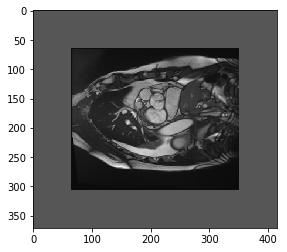

(1, 2, 371, 416)


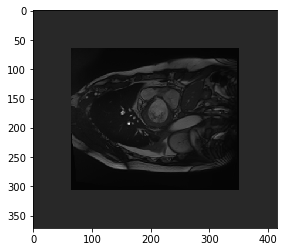

(1, 2, 371, 416)


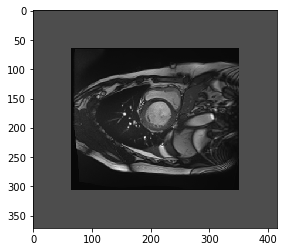

(1, 2, 371, 416)


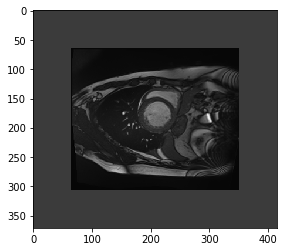

(1, 2, 371, 416)


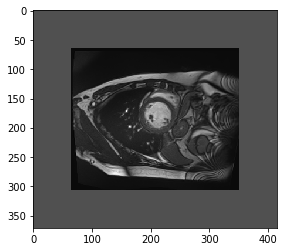

(1, 2, 371, 416)


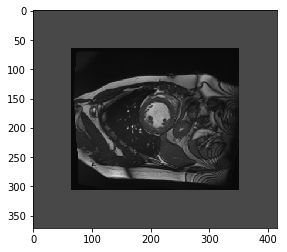

(1, 2, 371, 416)


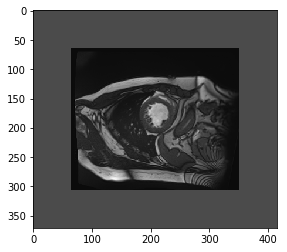

(1, 2, 371, 416)


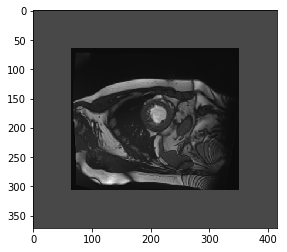

(1, 2, 371, 416)


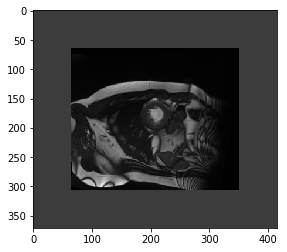

(1, 2, 371, 416)


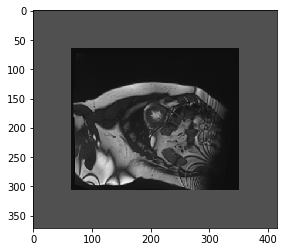

In [5]:
test_set.generate_batch(image_num=1, use_labels=True)

for batch_image, batch_labels in test_set.batch_generator():
    batch_image = batch_image.data.cpu().numpy()
    print(batch_image.shape)
    plt.imshow(batch_image[0,0], cmap=cm.gray)
    plt.show()


In [ ]:
loss_plot(exper, width=18, validation=True, log_scale=False,
          save=False, do_average=True) #, epoch_range=[40001, 50000])

Number of subplots 40


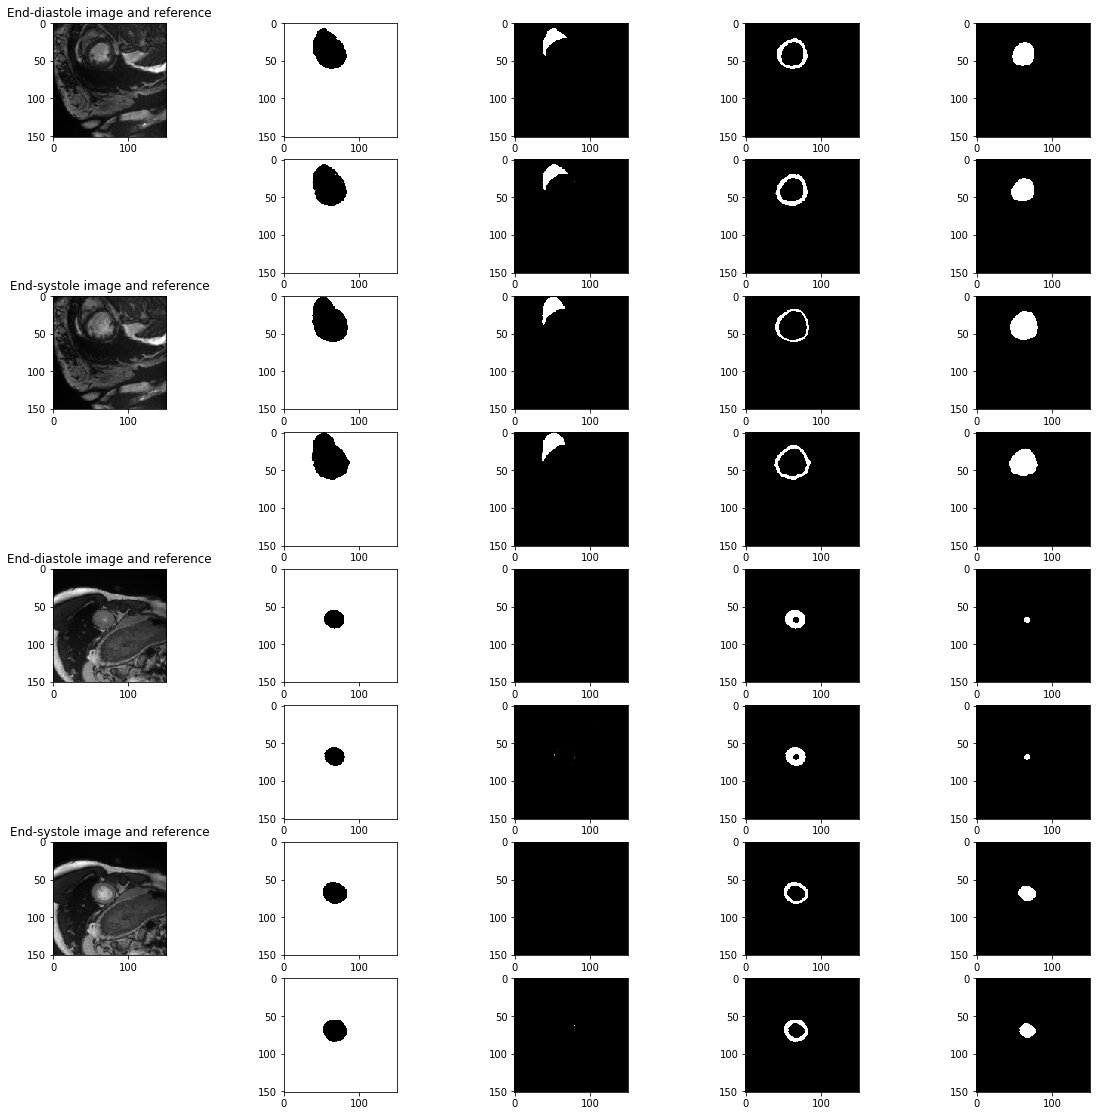

In [6]:
val_batch.visualize_batch(width=20, height=100, num_of_images=2)

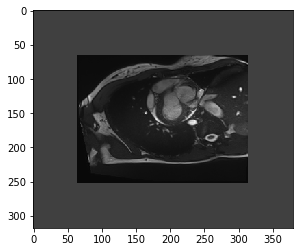

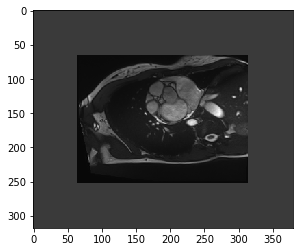

In [15]:
from in_out.read_save_images import load_mhd_to_numpy

idx = 888
image = dataset.images(train=True)[idx]
img_ed = image[0]
img_es = image[1]
plt.imshow(img_es, cmap=cm.gray)
plt.show()

plt.imshow(img_ed, cmap=cm.gray)
plt.show()

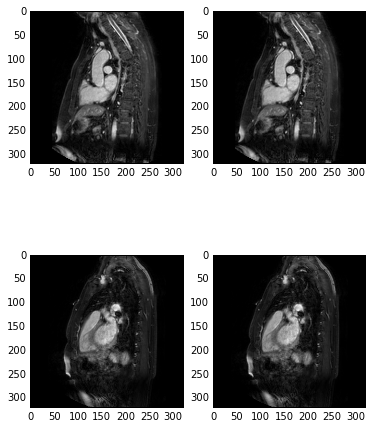

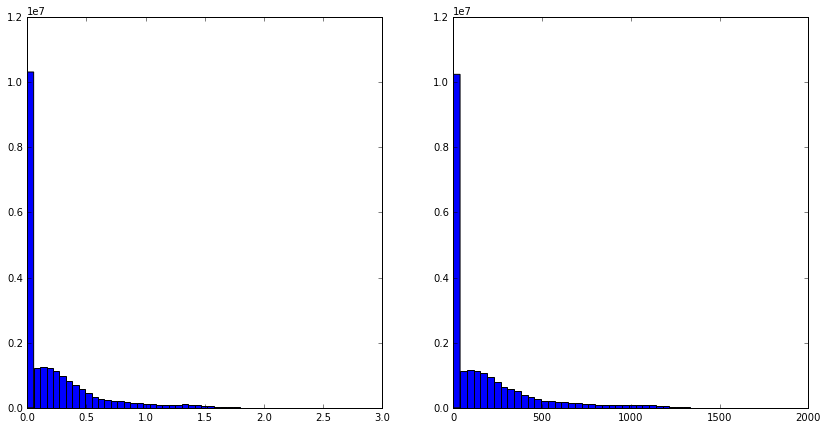

In [3]:

all_data_raw = np.empty(0)
all_data_norm = np.empty(0)

l_dataset = data_set.__len__()
series_idx = 50
fig = plt.figure(figsize=(6, 8))
counter = 0
data_set.normalize_values()

for idx in np.arange(l_dataset):
    img = data_set.images_raw[idx]
    img_norm = data_set.images[idx]
    all_data_raw = np.append(all_data_raw, np.ravel(img))
    all_data_norm = np.append(all_data_norm, np.ravel(img_norm))
    counter += 1
    ax = plt.subplot(l_dataset, 2, counter)
    plt.imshow(img[series_idx], cmap=cm.gray)
    counter += 1
    ax = plt.subplot(l_dataset, 2, counter)
    plt.imshow(img_norm[series_idx], cmap=cm.gray)

plt.show()
plt.close()

data_set.show_histogram(raw=True)